### Import Necessary libraries

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time

In [2]:
import torch
import torchvision
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms

### Train and Validation Dataset

To load the generate the data in required format, we can make use of dataset class.

In [3]:
def load_file(path):
    return np.load(path).astype(np.float32)

Next, we can define our train and validation transform:

In [4]:
# Transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.24),
    transforms.RandomAffine(degrees = (-5, 5), translate = (0, 0.05), scale = (0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale = (0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.24)
])

In [5]:
# Dataset

train_dataset = torchvision.datasets.DatasetFolder("./Processed/train", loader = load_file, extensions = "npy", transform = train_transforms)

val_dataset = torchvision.datasets.DatasetFolder("./Processed/val/", loader = load_file, extensions = "npy", transform = val_transforms)

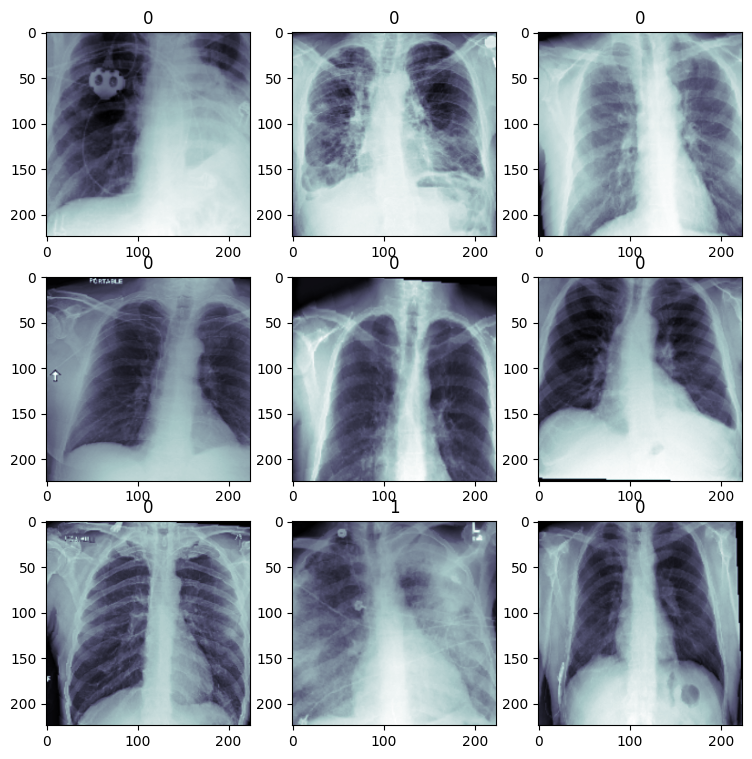

In [6]:
# Let's visualize 9 images from train dataset that are transformed 

fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(label)

In [7]:
# Dataloader
batch_size = 16
num_workers = 6

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle=False)

In [8]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

### Model Architecture

The following code defines a PyTorch Lightning module called PneumoniaModel for a binary classification task of detecting pneumonia from chest X-rays. The model architecture used is VGG-16.

In [9]:
model = torchvision.models.vgg16()

In [10]:
model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [11]:
model.classifier[3] = torch.nn.Linear(in_features = 4096, out_features = 512, bias = True)

In [12]:
model.classifier[6] = torch.nn.Linear(in_features=512, out_features=1, bias=True)

In [13]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
class PneumoniaModel(pl.LightningModule):
    
    # Constructor
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.vgg16()
        self.model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy(task = "binary")
        self.val_acc = torchmetrics.Accuracy(task = "binary")

        
        
    # Activation
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    
    
    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())
        
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))

        
        
       
    def on_validation_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())
        
        
    def configure_optimizers(self):
        return[self.optimizer]

In [15]:
model = PneumoniaModel()

In [16]:
model

PneumoniaModel(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [17]:
checkpoint_callback = ModelCheckpoint(
    monitor = 'Val ACC',
    save_top_k = 5,
    mode = 'max',
    dirpath = "./VGG-16 Output/saved_models"
)

In [18]:
devices = 1
trainer = pl.Trainer(accelerator='gpu', devices=devices, logger=TensorBoardLogger(save_dir='./VGG-16 Output/log'),
                    log_every_n_steps=1,
                    callbacks=checkpoint_callback, max_epochs=30)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
# Train the model
start_time = time.time()
torch.cuda.empty_cache()

trainer.fit(model, train_loader, val_loader)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken for training is : {total_time/3600} hours")

Missing logger folder: ./VGG-16 Output/log/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | VGG               | 134 M 
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.054   Total estimated model params size (MB)
2023-05-10 18:50:11.773466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 18:50:12.739643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Total time taken for training is : 5.687336614198155 hours


In [20]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
best_model = PneumoniaModel.load_from_checkpoint("./VGG-16 Output/saved_models/epoch=0-step=1500.ckpt")

In [22]:
best_model.eval()

PneumoniaModel(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [23]:
best_model.to(device)

PneumoniaModel(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [24]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        
        # Calculate probabilities
        pred = torch.sigmoid(best_model(data)[0].cpu())
        
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [25]:
# Accuracy
acc = torchmetrics.Accuracy(task = "binary")(preds, labels)

# Precision
precision = torchmetrics.Precision(task = "binary")(preds, labels)

# Recall
recall = torchmetrics.Recall(task = "binary")(preds, labels)

# Confusion Matrix
cm = torchmetrics.ConfusionMatrix(num_classes=2, task = "binary")(preds, labels)

In [26]:
print(f"Accuracy : {acc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"Confusion Matrix : {cm}")

Accuracy : 0.7932190895080566
Precision : 0.5396825671195984
Recall : 0.5619834661483765
Confusion Matrix : tensor([[1789,  290],
        [ 265,  340]])


### Class Activation Map

In [27]:

class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.vgg16()
        self.model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=1)
        
        self.feature_map =torch.nn.Sequential(*list(self.model.children())[0])
        
        
    def forward(self, data):
        feature_map = self.feature_map(data)
        #max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size = (7, 7))
        avg_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.classifier(avg_output_flattened)
        return pred, feature_map

In [28]:
model = PneumoniaModel.load_from_checkpoint("./VGG-16 Output/saved_models/epoch=0-step=1500.ckpt", strict = False)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:158: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.0.bias', 'feature_map.2.weight', 'feature_map.2.bias', 'feature_map.5.weight', 'feature_map.5.bias', 'feature_map.7.weight', 'feature_map.7.bias', 'feature_map.10.weight', 'feature_map.10.bias', 'feature_map.12.weight', 'feature_map.12.bias', 'feature_map.14.weight', 'feature_map.14.bias', 'feature_map.17.weight', 'feature_map.17.bias', 'feature_map.19.weight', 'feature_map.19.bias', 'feature_map.21.weight', 'feature_map.21.bias', 'feature_map.24.weight', 'feature_map.24.bias', 'feature_map.26.weight', 'feature_map.26.bias', 'feature_map.28.weight', 'feature_map.28.bias']
  rank_zero_warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:162: UserWarning: Found keys that are not in the model state dict but in the checkpoin

In [29]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0).to(device))
        pred, features = pred.to(device), features.to(device)
    features = features.reshape((512, 49))
    weight_params = list(model.model.classifier.parameters())[0][1].reshape(49, 512)
    weight = weight_params[0].detach()
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [30]:
def visualize(img, cam, pred):
    img = img[0].cpu().numpy()
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap = 'bone')
    axis[1].imshow(img, cmap= 'bone')
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred>0.5)

In [31]:
img_test, labels_test = val_dataset[-6]
print(img_test, labels_test)

tensor([[[ -2.0417,  -2.0417,  -2.0417,  ...,  -2.0417,   2.1250,  -2.0417],
         [ 64.6250,  43.7917,  35.4583,  ...,  22.9583,  22.9583,  22.9583],
         [ 52.1250,  39.6250,  31.2917,  ...,  22.9583,  22.9583,  22.9583],
         ...,
         [131.2917,  77.1250,  68.7917,  ..., 152.1250,  93.7917,  64.6250],
         [156.2917,  97.9583,  64.6250,  ..., 343.7917, 243.7917, 231.2917],
         [243.7917, 135.4583,  77.1250,  ...,  52.1250,  31.2917,  27.1250]]]) 1


In [32]:
img = val_dataset[-6][0]
activation_map, pred = cam(model, img)

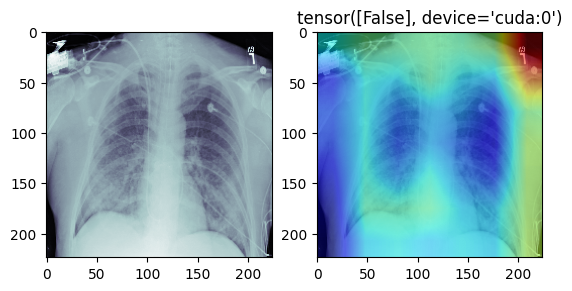

In [33]:
visualize(img, activation_map, pred)

In [34]:
img, labels = val_dataset[-800]
print(img, labels)

tensor([[[ 6.2917, 14.6250, 14.6250,  ..., -2.0417, -2.0417, -2.0417],
         [18.7917, 31.2917, 31.2917,  ..., -2.0417, -2.0417, -2.0417],
         [27.1250, 39.6250, 43.7917,  ..., -2.0417, -2.0417, -2.0417],
         ...,
         [-2.0417, -2.0417, -2.0417,  ..., -2.0417, -2.0417, -2.0417],
         [-2.0417, -2.0417, -2.0417,  ..., -2.0417, -2.0417, -2.0417],
         [-2.0417, -2.0417, -2.0417,  ..., -2.0417, -2.0417, -2.0417]]]) 0


In [35]:
if torch.cuda.is_available():
    model.cuda()

In [36]:
img = val_dataset[-800][0]
activation_map, pred = cam(model, img)

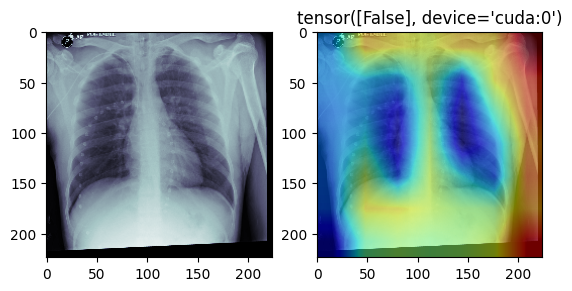

In [37]:
visualize(img, activation_map, pred)